In [37]:
#packages
import shap
import pandas as pd
import pickle
import copy
import seaborn as sns
from matplotlib import gridspec
import numpy as np
import os 
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score


In [23]:
# Load the dataset
train_full = pd.read_csv("/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/train-white.csv", sep=",")
test_full = pd.read_csv("/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/test-white.csv", sep=",")

In [24]:
# Prepare the data
target = "quality"
X_train = train_full.drop(columns=[target])
y_train = train_full[target]
X_test = test_full.drop(columns=[target])
y_test = test_full[target]

In [25]:
# Check the data
print("Train data preview:")
print(train_full.head())
print("\nTest data preview:")
print(test_full.head())

Train data preview:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            6.3              0.18         0.36             1.2      0.034   
1            6.8              0.14         0.18             1.4      0.047   
2            6.6              0.24         0.22            12.3      0.051   
3            6.5              0.37         0.30             2.2      0.033   
4            6.9              0.15         0.28             4.4      0.029   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 26.0                 111.0  0.99074  3.16       0.51   
1                 30.0                  90.0  0.99164  3.27       0.54   
2                 35.0                 146.0  0.99676  3.10       0.67   
3                 39.0                 107.0  0.98894  3.22       0.53   
4                 14.0                 107.0  0.99347  3.24       0.46   

   alcohol  quality  
0     11.0        6  
1     11.2        6  


In [26]:
# Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
#SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)  # Calculate SHAP values

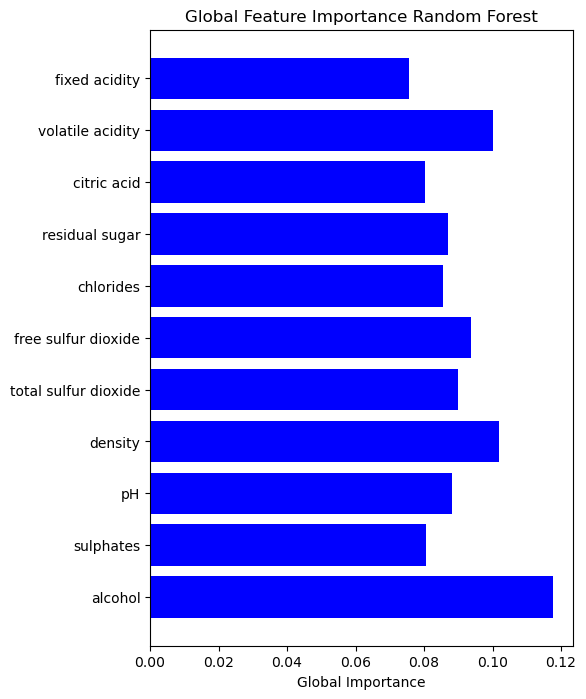

In [36]:
np.random.seed(42)
#  SHAP Explainer
explainer = shap.TreeExplainer(model)

# SHAP values
shap_values = explainer.shap_values(X_test)

class_index = 3  # Assuming class 6 corresponds to index 3
shap_values_class = shap_values[class_index]

instance_index = 3
shap_importances_local = shap_values_class[instance_index]

# global feature importances from the Decision Tree model
tree_feature_importances = model.feature_importances_
feature_names = X_test.columns.tolist()  # Get feature names from the dataset


# SHAP values matches the number of features
if len(shap_importances_local) != len(feature_names):
    shap_importances_padded = np.zeros(len(feature_names))
    shap_importances_padded[:len(shap_importances_local)] = shap_importances_local
    shap_importances_local = shap_importances_padded


# Plot 
plt.figure(figsize=(12, 8))

# Global feature importance plot
plt.subplot(1, 2, 1)
plt.title("Global Feature Importance Random Forest")
plt.barh(np.array(feature_names), tree_feature_importances, color='blue')
plt.xlabel("Global Importance")
plt.gca().invert_yaxis()


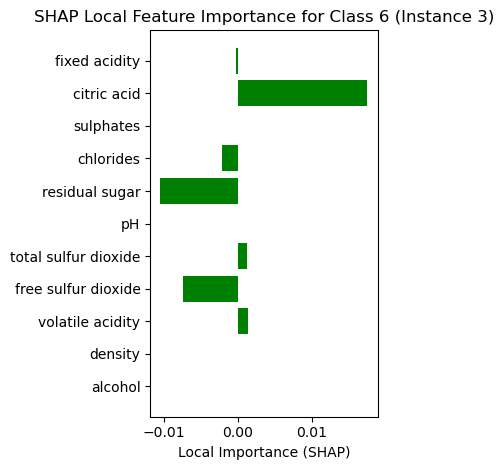

In [30]:
# Local SHAP feature importance plot
plt.subplot(1, 2, 2)
plt.title(f"SHAP Local Feature Importance for Class {class_index + 3} (Instance {instance_index})")
plt.barh(np.array(feature_names)[sorted_indices], np.array(shap_importances_local)[sorted_indices], color='green')
plt.xlabel("Local Importance (SHAP)")

plt.tight_layout()
plt.show()

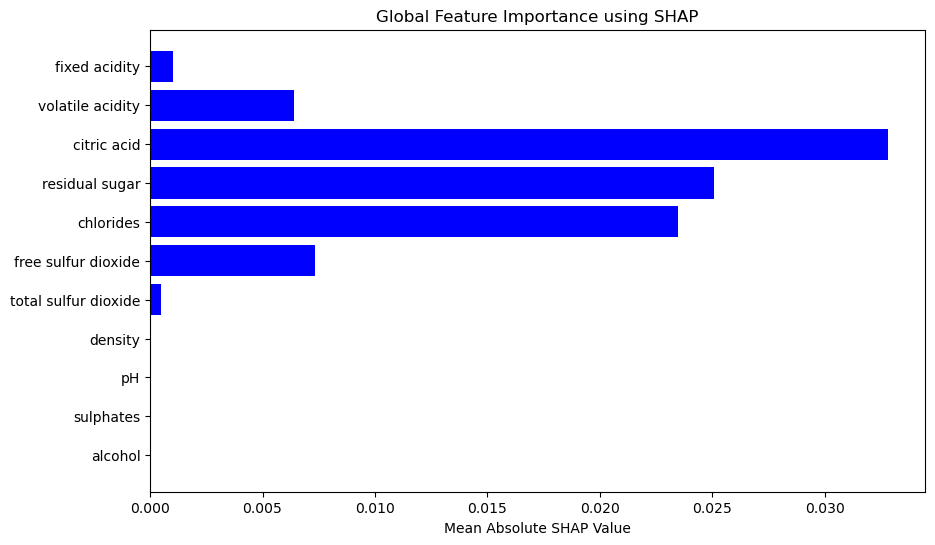

In [13]:
num_outputs = len(shap_values) 
num_features = X_test.shape[1]  


global_shap_values = np.zeros((num_outputs, num_features))

for i, shap_array in enumerate(shap_values):
    aggregated_shap = np.zeros(num_features)
    aggregated_shap[:shap_array.shape[1]] = np.mean(np.abs(shap_array), axis=0)  # Mean across instances
    global_shap_values[i] = aggregated_shap

#  mean absolute SHAP values across all outputs
global_shap_importance = np.mean(global_shap_values, axis=0)

# Plot
feature_names = X_test.columns.tolist()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, global_shap_importance, color='blue')
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Global Feature Importance using SHAP")
plt.gca().invert_yaxis()
plt.show()



In [9]:
# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.67


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predictions using Random Forest model
y_pred_rf = model.predict(X_test)  # Assuming 'model_rf' is your trained Random Forest model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE for Random Forest: {rmse_rf:.2f}")


RMSE for Random Forest: 0.68


In [31]:
#stability score
def calculate_stability_score_shap(instance, explainer, epsilon=0.1, num_samples=200):

    phi_original = explainer.shap_values(instance.reshape(1, -1))[0]

    #perturbed samples
    perturbations = np.random.normal(0, epsilon, size=(num_samples, instance.shape[0]))
    perturbed_samples = np.clip(instance + perturbations, X_train.values.min(axis=0), X_train.values.max(axis=0))

    max_stability = 0
    for perturbed_instance in perturbed_samples:
        phi_perturbed = explainer.shap_values(perturbed_instance.reshape(1, -1))[0]
        phi_diff = np.linalg.norm(phi_original - phi_perturbed, ord=2)
        input_diff = np.linalg.norm(instance - perturbed_instance, ord=2)
        stability = phi_diff / (input_diff + 1e-8)  # Avoid division by zero
        max_stability = max(max_stability, stability)

    return max_stability

# Create SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model)

# stability scores for 10 instances
num_instances = 50
stability_scores_rf_shap = [calculate_stability_score_shap(X_test.iloc[i].values, explainer) for i in range(num_instances)]

# results
print("Stability scores for RF + SHAP:", stability_scores_rf_shap)



Stability scores for RF + SHAP: [1.254212907713822, 1.4175290093065935, 1.5239447128815313, 1.2941732611395425, 1.7508145046650683, 0.9271174308319058, 1.8203759770223242, 1.3558229770136705, 1.5038462748321724, 2.3537805162386656, 1.8881468586559775, 1.606234556473288, 1.533796872515853, 1.3050661072203396, 1.156760643012475, 1.671670744705432, 1.7983944170072146, 0.9332385226716735, 1.3607725074760257, 2.081617166966316, 1.075604160163699, 1.4346313802097368, 1.6281849210485753, 1.1397444064995228, 1.6755076392205335, 1.2697159539696434, 1.3118418740026394, 2.2101860630408163, 1.371679409558413, 2.1458881066828037, 1.309104620076448, 2.023992584056375, 2.506864793657062, 1.5601046802831253, 1.330013447470032, 1.1729970880229919, 2.3535394763501007, 1.5454234931290416, 1.2847591253251778, 2.0641955268436205, 1.2518158546641736, 1.6576196793730469, 2.411739963967512, 1.474576807859043, 1.6960736151203006, 1.4541098966444288, 1.8836091565676483, 1.7250678372702952, 2.0037431267994026, 1

In [33]:
#function to get feature importance vector using SHAP
def get_shap_feature_importance(instance, model, explainer):

    shap_values = explainer.shap_values(instance)
    # For multi-class models, choose the SHAP values of the target class (e.g., class 0)
    phi = np.array(shap_values[0])  # Assuming binary classification, adjust for your case
    return phi

# Example usage for 10 instances
shap_feature_importances = []
for i in range(2): 
    instance = X_test.iloc[i].values
    phi = get_shap_feature_importance(instance, model, explainer)
    shap_feature_importances.append(phi)

shap_feature_importances = np.array(shap_feature_importances)
print("consistancy scores for RF + SHAP:", shap_feature_importances)

shap_values = explainer.shap_values(X_test)
shap_feature_names = X_test.columns.tolist() 
print("SHAP feature names:", shap_feature_names)



consistancy scores for RF + SHAP: [[ 5.59990063e-04 -3.68247414e-03  6.88072689e-03 -7.95668334e-03
   3.98373380e-03  1.04683494e-04  1.10023224e-04]
 [ 1.33545541e-04 -8.11637005e-03  1.44061971e-02 -6.04007578e-03
  -6.23404041e-04  1.84097303e-04  5.60098840e-05]
 [-1.41530715e-04 -1.55913380e-03 -4.76394197e-03  1.97741059e-02
  -1.31116165e-03 -1.00184303e-02 -1.97990750e-03]
 [-1.22378003e-03 -3.82949591e-03 -7.57476628e-03  1.87306868e-03
   1.51271027e-02 -7.21699604e-03  2.84486688e-03]
 [-4.45262745e-04  4.32616592e-04 -8.81298307e-03  1.74485420e-03
  -6.56919114e-02  7.36669594e-02 -8.94272918e-04]
 [ 1.71617547e-04 -1.76685636e-03 -1.35245922e-02  1.92873712e-03
   1.07068190e-02  2.28992742e-03  1.94347506e-04]
 [ 2.79582042e-04  4.74535143e-03 -2.98310320e-02 -1.07690581e-02
  -6.33197119e-03  4.04632808e-02  1.44384714e-03]
 [-4.75454918e-04 -1.41145949e-03  1.11194318e-02 -2.06482639e-02
   1.01188585e-02  4.83072494e-04  8.13815544e-04]
 [ 6.62907424e-04 -6.57806040e

In [41]:

# Define a function to get feature importance vector using SHAP
def get_shap_feature_importance(instance, model, explainer):
    shap_values = explainer.shap_values(instance)
    # For multi-class models, choose the SHAP values of the target class (e.g., class 0)
    phi = np.array(shap_values[0])  # Assuming binary classification, adjust for your case
    return phi

# Example usage for 10 instances
shap_feature_importances = []
for i in range(2):  # Assuming you want to extract for 10 instances
    instance = X_test.iloc[i].values
    phi = get_shap_feature_importance(instance, model, explainer)
    shap_feature_importances.append(phi)

shap_feature_importances = np.array(shap_feature_importances)
print("consistancy scores for RF + SHAP:", shap_feature_importances)



consistancy scores for RF + SHAP: [[ 5.59990063e-04 -3.68247414e-03  6.88072689e-03 -7.95668334e-03
   3.98373380e-03  1.04683494e-04  1.10023224e-04]
 [ 1.33545541e-04 -8.11637005e-03  1.44061971e-02 -6.04007578e-03
  -6.23404041e-04  1.84097303e-04  5.60098840e-05]]
